# Regularization of ANN weights


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg).

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
data = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Check is there are missing entries in the dataset.

In [4]:
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


Remove records with missing entries.

In [5]:
data = data.dropna()
print(data.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


## Data inspection

Display some basic information.

In [6]:
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [8]:
data.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


We are interested in predicting the field `MPG`, measuring [fuel efficiency](https://en.wikipedia.org/wiki/Fuel_efficiency#:~:text=Fuel%20economy%20is%20the%20distance,a%20certain%20volume%20of%20fuel)), expressed in miles per gallon (MPG), where 1 MPG = 0.354006 km/L. Plot its distribution.

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


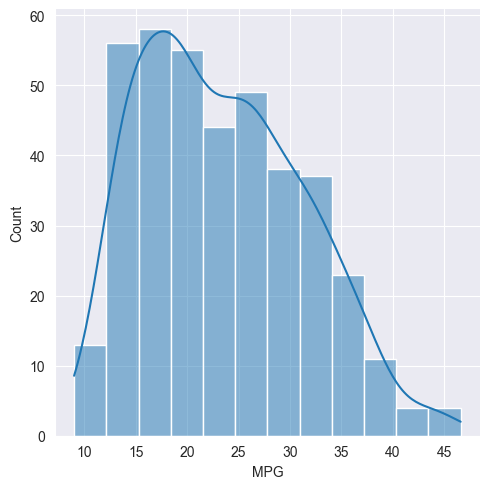

In [9]:
sns.displot(data['MPG'], kde = True)

Look for linear correlations among data.

In [10]:
data.corr()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
MPG,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
Cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
Displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
Horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
Weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
Acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
Model Year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
Origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


<Axes: >

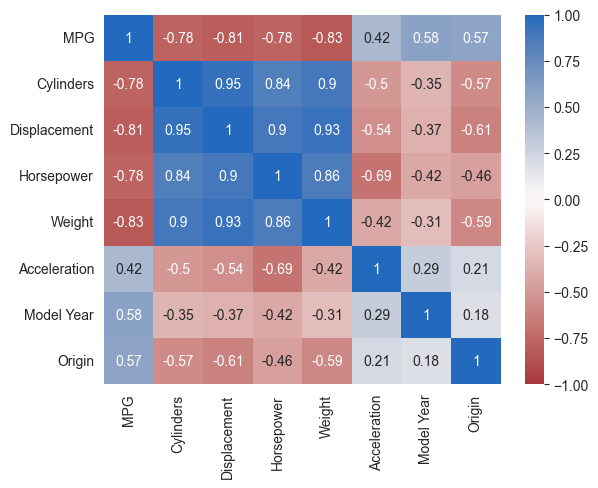

In [11]:
sns.heatmap(data.corr(), annot = True, cmap = 'vlag_r', vmin = -1, vmax = 1)

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


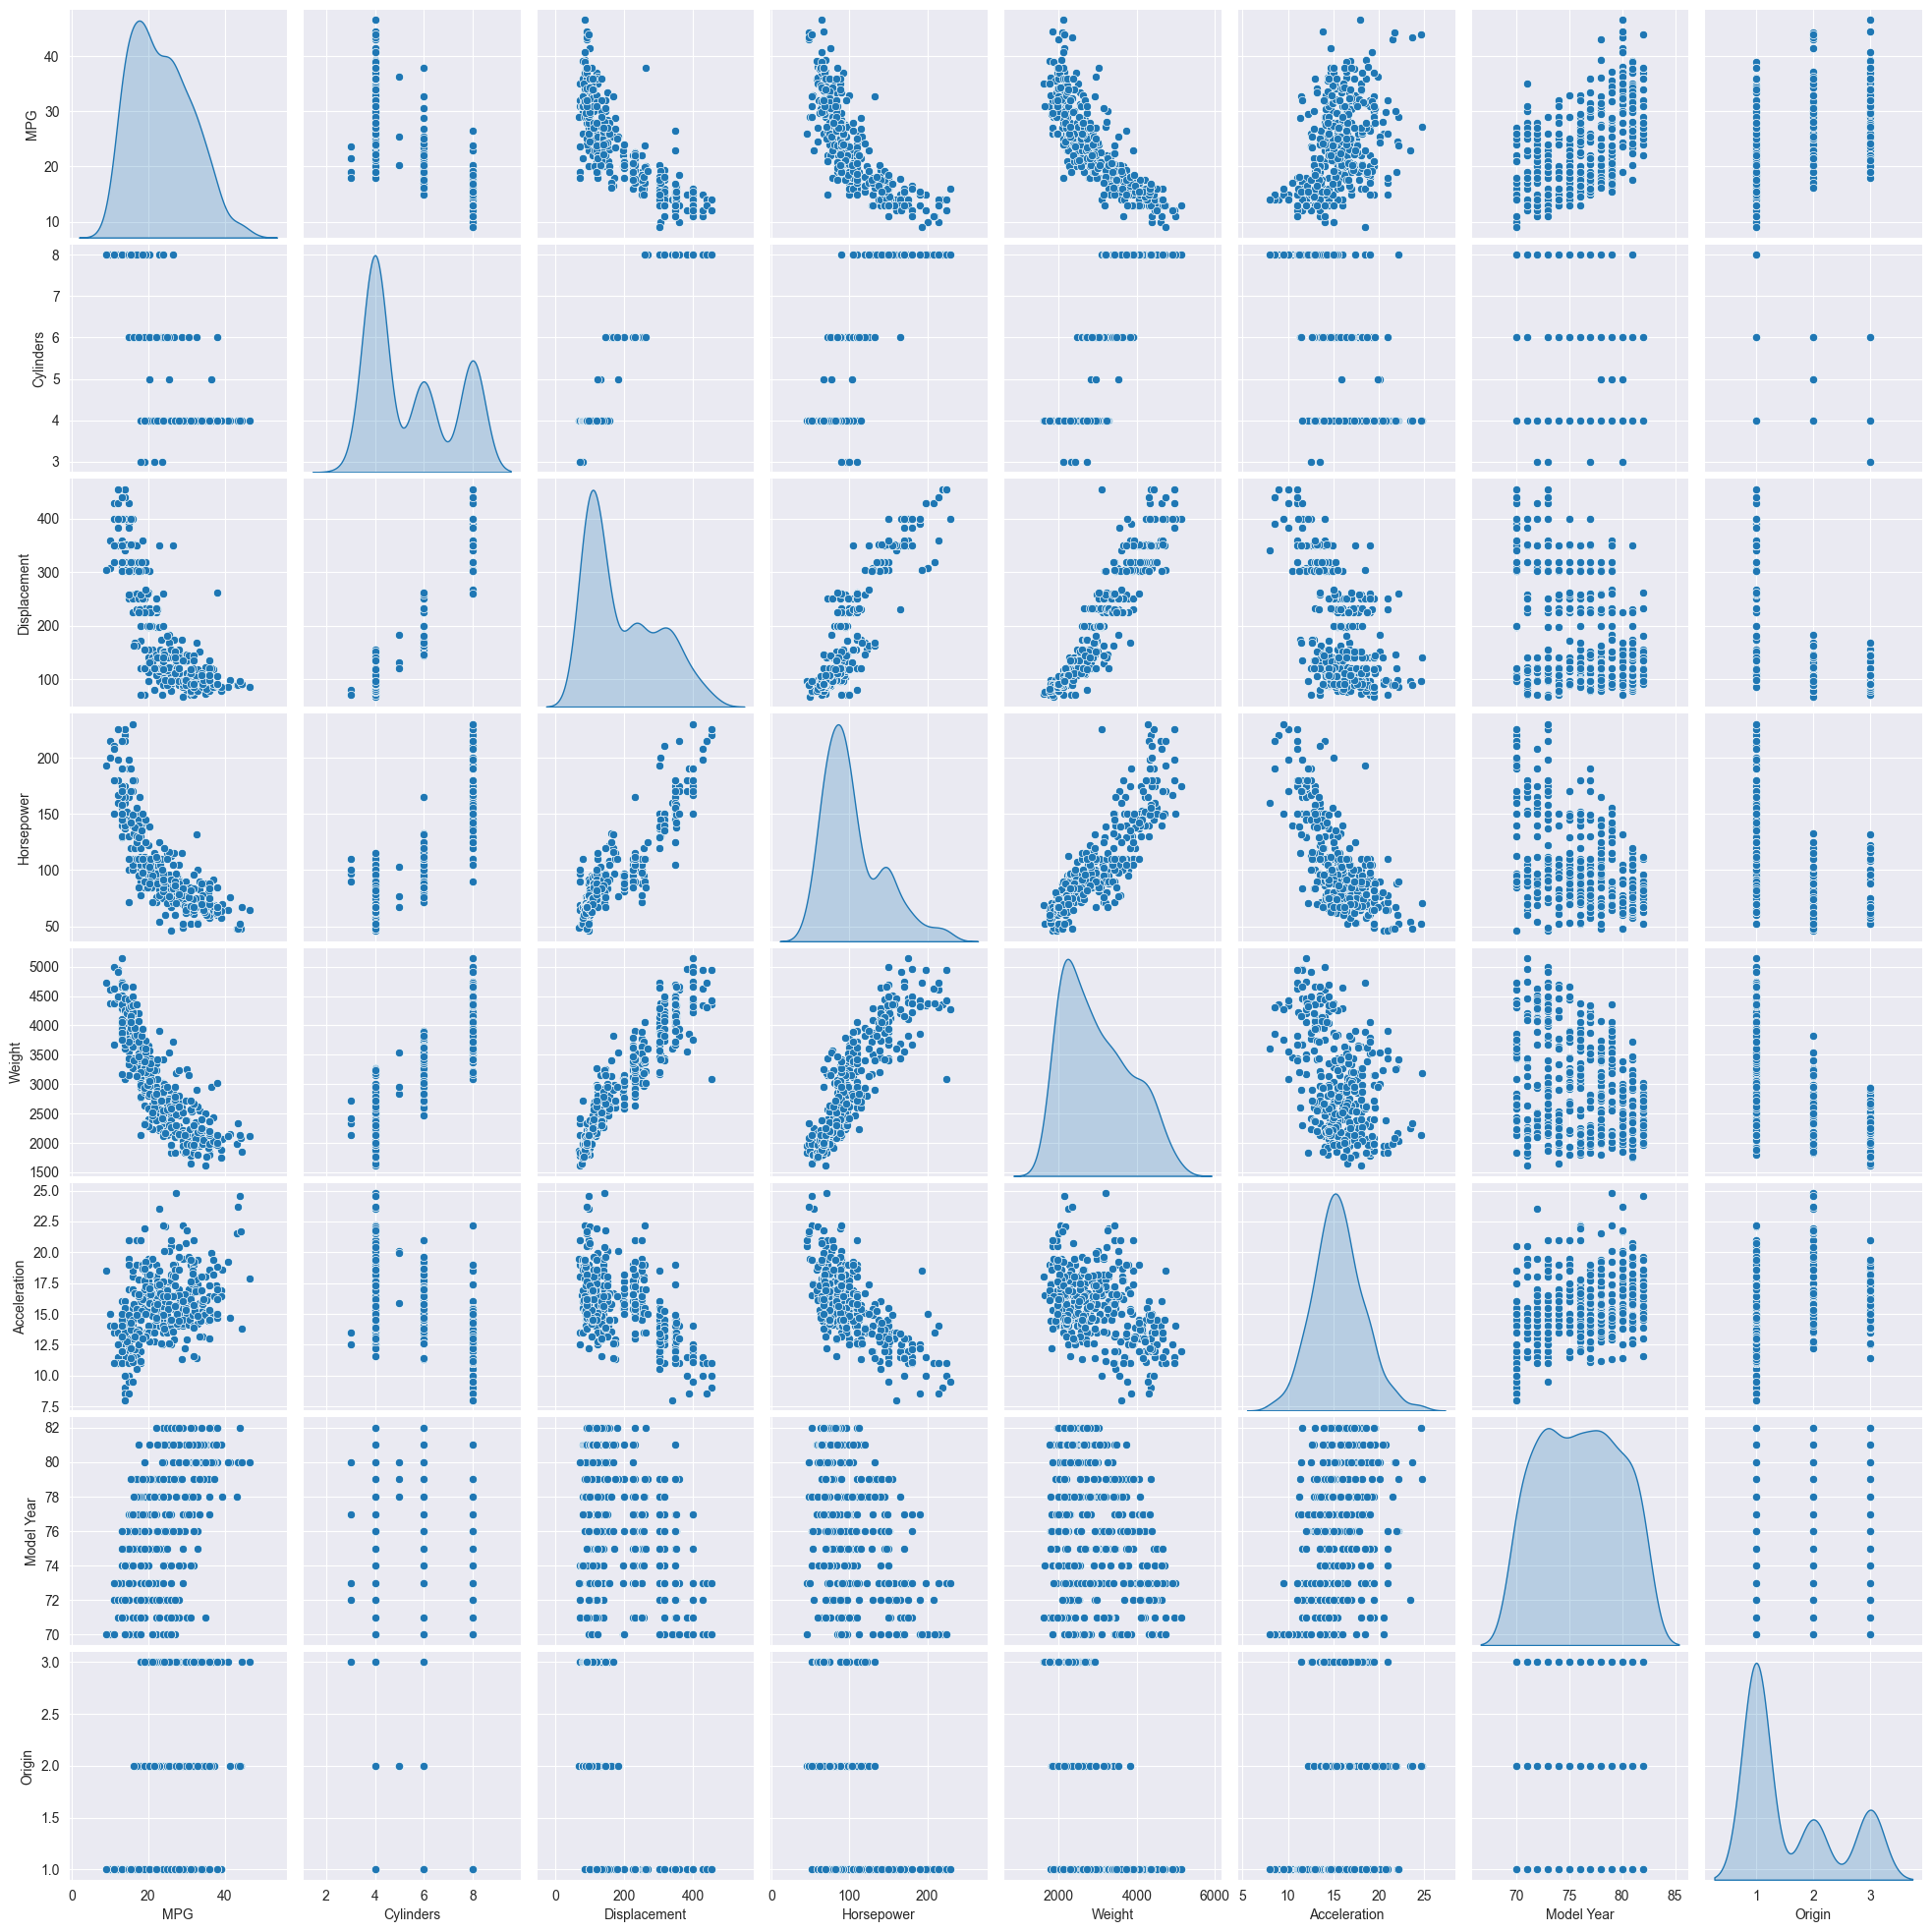

In [12]:
sns.pairplot(data, diag_kind='kde')

## Data normalization

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.

In [13]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

<Axes: >

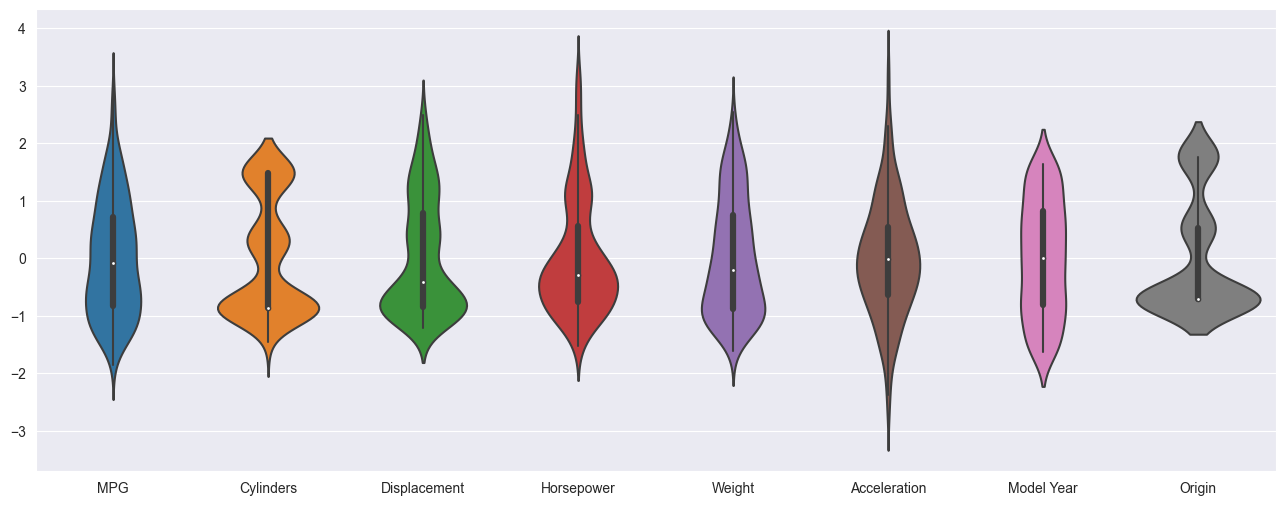

In [14]:
_, ax = plt.subplots(figsize=(16,6))
sns.violinplot(data = data_normalized, ax = ax)

## Train-validation split

Shuffle the data using the [np.random.shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) function and split the data as follows:
- put 80% in the train dataset
- put 20% in the validation dataset

In [15]:
data_normalized_np = data_normalized.to_numpy()
np.random.seed(0)
np.random.shuffle(data_normalized_np)

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train,1:]
y_train = data_normalized_np[:num_train,:1]
x_valid = data_normalized_np[num_train:,1:]
y_valid = data_normalized_np[num_train:,:1]

print('train set size     : %d' % x_train.shape[0])
print('validation set size: %d' % x_valid.shape[0])

train set size     : 313
validation set size: 79


## ANN setup

Write a function `params = initialize_params(layers_size)` that initializes the parameters, given the ANN architecture.
Initialize biases with zero values, and weights with a [Glorot Normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization, i.e. sampling from a Gaussian distribution with zero mean and with standard deviation 
$$
\sqrt{\frac{2}{n + m}},
$$
where $n$ and $m$ are the number of input and output neurons of the corresponding weights matrix.


In [16]:
def initialize_params(layers_size):
  np.random.seed(0) # for reproducibility
  params = list()
  for i in range(len(layers_size) - 1):
    n, m = layers_size[i + 1], layers_size[i]
    params.append(np.random.normal(0, np.sqrt(2 / (n + m)), (n, m)))
    params.append(np.zeros((n, 1)))
  return params

Implement a generic feedforward ANN with a function `y = ANN(x, params)`, using $ReLU$ as activation function.

In [17]:
activation = lambda x: jnp.maximum(0.0, x)

def ANN(x, params):
    temp = x.T
    for i in range(0, len(params), 2):
      if i == len(params) - 2:
        temp = params[i] @ temp + params[i + 1]
      else:
        temp = jnp.maximum(params[i] @ temp + params[i + 1], 0)
    return temp.T


params = initialize_params([7, 10, 1])
ANN(x_train[:10,:], params)

Array([[-0.27655408],
       [-0.15536341],
       [ 0.48314786],
       [-0.56939894],
       [-0.00754281],
       [ 0.01332847],
       [ 0.02310115],
       [ 0.27127817],
       [ 0.35476035],
       [ 0.08180778]], dtype=float32)

Implement the quadratic loss (MSE) function `L = MSE(x, y, params)`.

In [18]:
def MSE(x, y, params):
  pred = ANN(x, params)[:, 0]
  real = y[:, 0]
  return jnp.mean(jnp.square(pred - real))

params = initialize_params([7, 10, 1])
print(MSE(x_train, y_train, params))

mse_fast = jax.jit(MSE)

1.3815352


Implement an $l^2$ regularization term for the ANN weights:
$$
\mathrm{MSW} = \frac{1}{n_{weights}} \sum_{i=1}^{n_{weights}} w_i^2
$$
and define the loss function as
$$
\mathcal{L} = \mathrm{MSE} + \beta \, \mathrm{MSW}
$$
where $\beta$ is a suitable penalization parameter.

In [19]:
def MSW(params, beta=0.1):
  res, n = 0, 0
  for i in range(0, len(params), 2):
    res += jnp.sum(jnp.square(params[i]))
    n += params[i].shape[0] * params[i].shape[1]
  return res * (beta / n)

msw_fast = jax.jit(MSW)

def loss(x, y, params, penalization):
  return MSE(x, y, params) + MSW(params, penalization)

print(MSW(params))
print(loss(x_train, y_train, params, 1.0))

0.012336959
1.5049047


Run this cell: we will this callback to monitor training.

In [20]:
from IPython import display

class Callback:
  def __init__(self, refresh_rate = 250):
    self.refresh_rate = refresh_rate
    self.fig, self.axs = plt.subplots(1, figsize=(16,8))
    self.epoch = 0
    self.__call__(-1)

  def __call__(self, epoch):
    self.epoch = epoch
    if (epoch + 1) % self.refresh_rate == 0:
      self.draw()
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1e-16)

  def draw(self):
    if self.epoch > 0:
      self.axs.clear()
      self.axs.loglog(history_loss_train, 'b-', label = 'loss train')
      self.axs.loglog(history_loss_valid, 'r-', label = 'loss validation')
      self.axs.loglog(history_MSE_train, 'b--', label = 'RMSE train')
      self.axs.loglog(history_MSE_valid, 'r--', label = 'RMSE validation')
      self.axs.legend()
      self.axs.set_title('epoch %d' % (self.epoch + 1))

## Training

Train an ANN with two hidden layers with 20 neurons each, using 5000 epochs of the SGD method (with minibatch size 100) with momentum ($\alpha = 0.9$).
Employ a linear decay of the learning rate:
$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$
with $\lambda_{\textnormal{min}} = 5e-3$, $\lambda_{\textnormal{max}} = 1e-1$ and decay length $K= 1000$.

During training, store both the MSE error and the loss function obtained on the train and validation sets in 4 lists, respectively called:
- `history_loss_train`
- `history_loss_valid`
- `history_MSE_train`
- `history_MSE_valid`

Test different choices of the penalization parameter $\beta$.



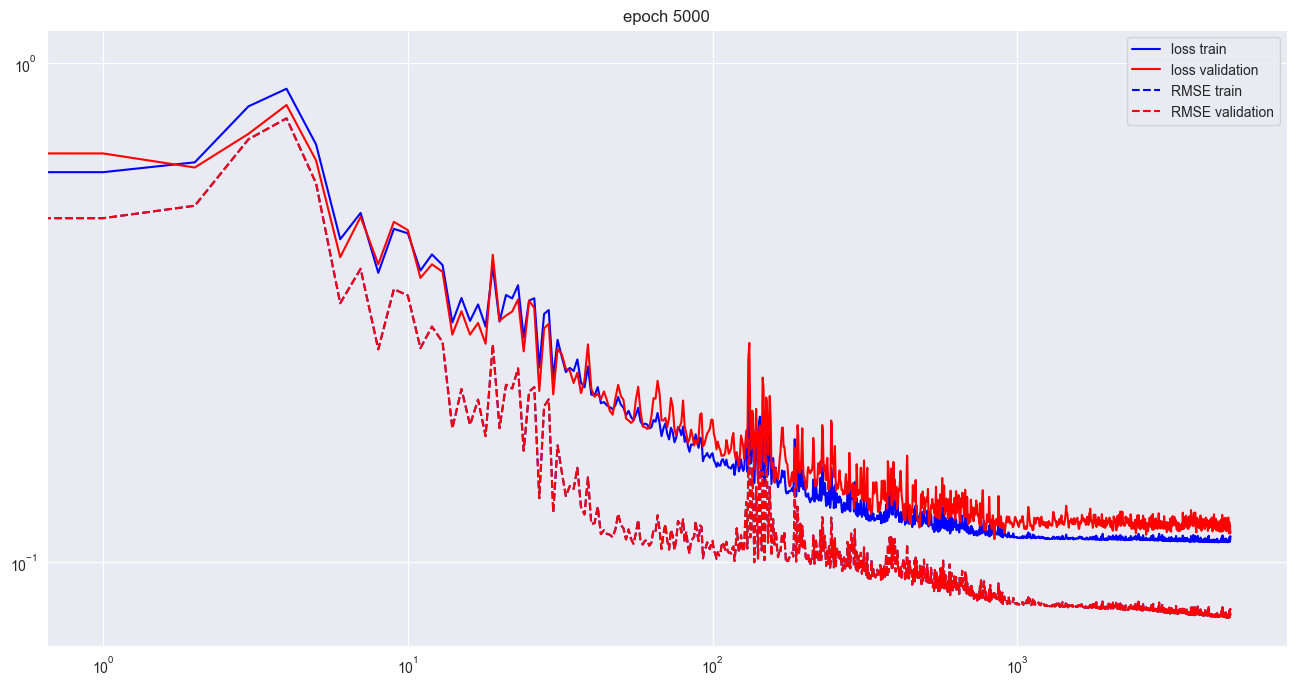

loss (train     ): 1.122e-01
loss (validation): 1.149e-01
MSE  (train     ): 8.004e-02
MSE  (validation): 8.004e-02


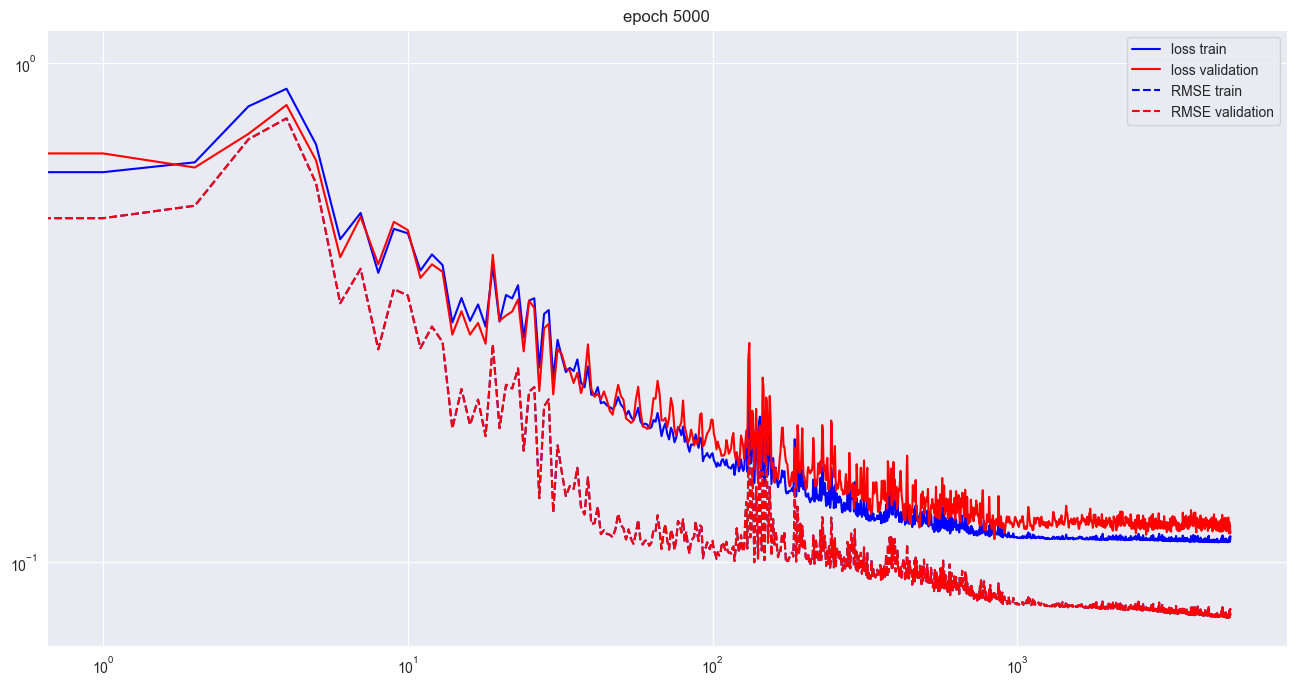

In [23]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
penalization = 0.0
# Training options
num_epochs = 5000
lr_max = 1e-1
lr_min = 5e-3
lr_decay = 1000
batch_size = 100
alpha = 0.9
########################################

dec_lr = lambda i: max(lr_min, lr_max * (1 - i / lr_decay)) # linear decay

params = initialize_params(layers_size)
grad_jit = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)

history_loss_train = list()
history_loss_valid = list()
history_MSE_train = list()
history_MSE_valid = list()

cb = Callback(refresh_rate = 500)

v = [0 for _ in range(len(params))]
beta = 0.1 # overfitting
beta = 2 # non overfitting

for epoch in range(num_epochs):
  idx = np.random.choice(np.arange(x_train.shape[0]), batch_size, replace=True)
  grads = grad_jit(x_train[idx], y_train[idx], params, beta)
  learning_rate = dec_lr(epoch)
  for i in range(len(params)):
    v[i] = alpha * v[i] - learning_rate * grads[i] # new grads are more significant than the others -- exponential weighting
    params[i] += v[i]
  history_loss_train.append(loss_jit(x_train, y_train, params, beta))
  history_loss_valid.append(loss_jit(x_valid, y_valid, params, beta))
  history_MSE_train.append(mse_fast(x_train, y_train, params))
  history_MSE_valid.append(mse_fast(x_train, y_train, params))
  cb(epoch)

print('loss (train     ): %1.3e' % history_loss_train[-1])
print('loss (validation): %1.3e' % history_loss_valid[-1])
print('MSE  (train     ): %1.3e' % history_MSE_train[-1])
print('MSE  (validation): %1.3e' % history_MSE_valid[-1])

We now want to to investigate more in depth the effect of the penalization parameter $\beta$.
Write a function that, given the penalization parameter, trains the ANN (with the same setting used above) and returns a dictionary containing the final values of:
- train MSE
- validation MSE
- MSW

In [22]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
# Training options
num_epochs = 5000
lr_max = 1e-1
lr_min = 5e-3
lr_decay = 1000
batch_size = 100
alpha = 0.9

def train(penalization):
  lr_min = 1e-2
  lr_max = 1e-1

  dec_lr = lambda i: max(lr_min, lr_max * (1 - i / lr_decay)) # linear decay

  params = initialize_params(layers_size)
  grad_jit = jax.jit(jax.grad(loss, argnums=2))

  v = [0 for _ in range(len(params))]
  beta = penalization

  for epoch in range(num_epochs):
    idx = np.random.choice(np.arange(x_train.shape[0]), batch_size, replace=True)
    grads = grad_jit(x_train[idx], y_train[idx], params, beta)
    learning_rate = dec_lr(epoch)
    for i in range(len(params)):
      v[i] = alpha * v[i] - learning_rate * grads[i] # new grads are more significant than the others -- exponential weighting
      params[i] += v[i]

  return {
      'MSE_train'  : mse_fast(x_train, y_train, params),
      'MSE_valid'  : mse_fast(x_valid, y_valid, params),
      'MSW'        : msw_fast(params, beta)
      }

Using the above defined function, store the obtained results for $\beta = 0, 0.25, 0.5, 0.75, \dots, 2$.

In [23]:
history = [train(x) for x in list(np.arange(0, 2.25, 0.25))]

Plot the trend of the quantities as functions of $\beta$.

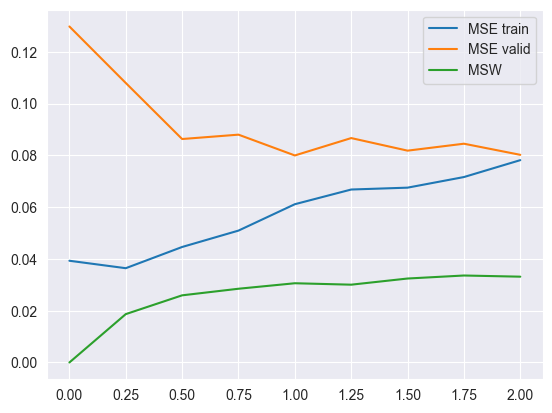

In [24]:
plt.plot(list(np.arange(0, 2.25, 0.25)), [x["MSE_train"] for x in history], label="MSE train")
plt.plot(list(np.arange(0, 2.25, 0.25)), [x["MSE_valid"] for x in history], label="MSE valid")
plt.plot(list(np.arange(0, 2.25, 0.25)), [x["MSW"] for x in history], label="MSW")
plt.legend() # i risultati spiegano come all'aumentare di beta aumenta MSW e diminuisce overfitting

Plot the *Tikhonov L-curve*, which is - in this context - the curve "train MSE" versus "MSW".

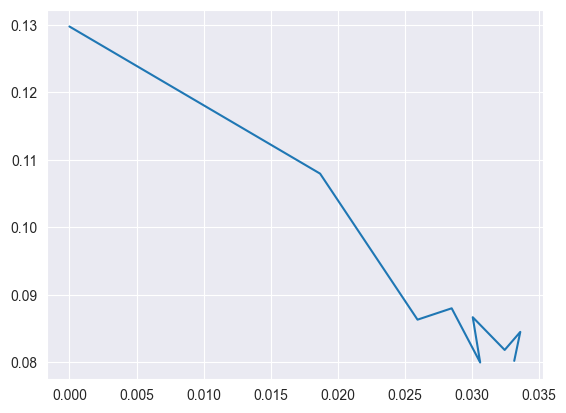

In [35]:
plt.plot([x["MSW"] for x in history], [x["MSE_valid"] for x in history])

In [ ]:
# il punto che cerchi è l'elbow del grafico --> punto in cui c'è il migliore compromesso per il valore di beta